In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import analyze_utils

save_dir = '/home/jxm3/research/prompting/interpretable-autoprompting/results_icml/ablation2_rerun'

r, all_losses = analyze_utils.load_results_and_cache_autoprompt_json(
    save_dir, save_file='r.pkl', do_reranking=True, include_losses=True
)

getting dir_names...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 317/317 [00:12<00:00, 25.35it/s]


In [72]:
len(r)

112592

In [73]:
top_prompts = (
    r.groupby(['task_name', 'n_shots', 'iprompt_conditioning_strategy', 'single_shot_loss', 'seed'])
).first().reset_index()
print(len(top_prompts))
top_prompts['r@128'] = top_prompts['reciprocal_rank'].map(lambda r: (1.0/r) <128.1)
# top_prompts[['task_name', 'seed', 'max_digit', 'prefixes', 'reciprocal_rank']]

317


In [74]:
MATH_TASK_NAMES = {
    'add_two', 'multiply_two', 'subtract_two', 'max_two', 
    'first_two', 'square_one', 'double_one', 'exp_one',  
    'fibonacci_one', 'divide_two'
}
TASK_IS_MATH = top_prompts['task_name'].map(lambda t: t in MATH_TASK_NAMES)
TASK_IS_ANLI = top_prompts['task_name'].map(lambda t: t not in MATH_TASK_NAMES)

In [75]:
pd.set_option('display.max_rows', None)
# top_prompts[(top_prompts['single_shot_loss'] == 1) & (top_prompts['iprompt_conditioning_strategy'] == "")].sort_values(by='task_name')[['n_shots', 'task_name', 'prefixes', 'reciprocal_rank']]

In [76]:
top_prompts[TASK_IS_MATH].groupby(['n_shots', 'single_shot_loss', 'iprompt_conditioning_strategy']).mean()['reciprocal_rank']

n_shots  single_shot_loss  iprompt_conditioning_strategy
5        0                                                  1.000000e-10
         1                                                  5.574514e-01
                           unconditional                    3.995389e-01
                           x_only                           5.389817e-01
                           y_only                           4.625731e-01
Name: reciprocal_rank, dtype: float64

In [77]:
top_prompts[TASK_IS_ANLI].groupby(['n_shots', 'single_shot_loss', 'iprompt_conditioning_strategy']).mean()['reciprocal_rank']

n_shots  single_shot_loss  iprompt_conditioning_strategy
5        1                                                  0.283114
                           unconditional                    0.015042
                           x_only                           0.253196
                           y_only                           0.243369
Name: reciprocal_rank, dtype: float64

In [78]:
top_prompts.groupby(['n_shots', 'single_shot_loss', 'iprompt_conditioning_strategy']).mean()['reciprocal_rank']

n_shots  single_shot_loss  iprompt_conditioning_strategy
5        0                                                  1.000000e-10
         1                                                  4.220188e-01
                           unconditional                    2.097242e-01
                           x_only                           3.978974e-01
                           y_only                           3.543586e-01
Name: reciprocal_rank, dtype: float64

In [79]:
top_prompts.groupby(['n_shots', 'single_shot_loss', 'iprompt_conditioning_strategy']).mean()['reciprocal_rank']

n_shots  single_shot_loss  iprompt_conditioning_strategy
5        0                                                  1.000000e-10
         1                                                  4.220188e-01
                           unconditional                    2.097242e-01
                           x_only                           3.978974e-01
                           y_only                           3.543586e-01
Name: reciprocal_rank, dtype: float64

## plot losses as lines.

In [21]:
len(all_losses), len(top_prompts)

(258, 258)

In [22]:
import numpy as np
max_loss_len = max([len(L) for L in all_losses])

all_losses_padded = []
for L in all_losses:
    last_val = L[-1]
    all_losses_padded.append(
        L + [last_val] * (max_loss_len - len(L))
    )
all_losses_padded = np.array(all_losses_padded)

In [23]:
(top_prompts['reciprocal_rank'] > 0.5).sum()

79

/tmp/ipykernel_3519924/2549526205.py:34: RuntimeWarning: Mean of empty slice.
  plt.plot(X_AXIS, all_losses_padded[MASK & TASK_IS_MATH & (top_prompts['reciprocal_rank'] < 0.2)].mean(axis=0), color=COLOR, label=LABEL)
/home/jxm3/.conda/envs/torch/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


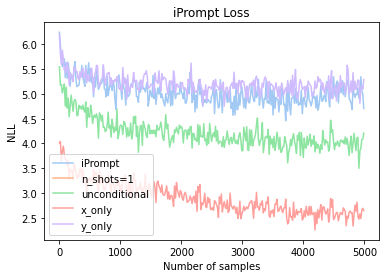

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

COLORS = sns.color_palette("pastel", 6)

#############################################

DEFAULT = (
    (top_prompts['n_shots'] == 5) & (top_prompts['iprompt_conditioning_strategy'] == "") & (top_prompts["single_shot_loss"] == 1)
)
NSHOTS_1 = (
    top_prompts['n_shots'] == 1
)
COND_UNCONDITIONAL = (
    top_prompts['iprompt_conditioning_strategy'] == 'unconditional'
)
COND_XONLY = (
    top_prompts['iprompt_conditioning_strategy'] == 'x_only'
)
COND_YONLY = (
    top_prompts['iprompt_conditioning_strategy'] == 'y_only'
)

BATCH_SIZE = top_prompts['batch_size'].unique()[0]
X_AXIS = np.arange(all_losses_padded.shape[1]) * BATCH_SIZE

#############################################

for MASK, LABEL, COLOR in zip(
        [DEFAULT, NSHOTS_1, COND_UNCONDITIONAL, COND_XONLY, COND_YONLY], 
        ['iPrompt', 'n_shots=1', 'unconditional', 'x_only', 'y_only'],
        COLORS
    ):
    plt.plot(X_AXIS, all_losses_padded[MASK & TASK_IS_MATH & (top_prompts['reciprocal_rank'] < 0.2)].mean(axis=0), color=COLOR, label=LABEL)

#############################################

plt.title('iPrompt Loss')
plt.xlabel('Number of samples')
plt.ylabel('NLL')
plt.legend()

In [25]:
def label_exp(r): 
    if (r['n_shots'] == 5) & (r['iprompt_conditioning_strategy'] == "") & (r["single_shot_loss"] == 1):
        return 'Default'
    elif r['n_shots'] == 1:
        return 'Zero-shot generation'
    elif r['iprompt_conditioning_strategy'] == 'unconditional':
        return 'Unconditional generation'
    elif r['single_shot_loss'] == 0:
        return 'No single-shot loss'
    elif r['iprompt_conditioning_strategy'] == 'x_only':
        return 'x-conditioned generation'
    elif r['iprompt_conditioning_strategy'] == 'y_only':
        return 'y-conditioned generation'
    else:
        print(r)
        raise ValueError('unknown exp for row')
    
# r['exp'] = r.apply(label_exp, axis=1)
top_prompts['exp'] = top_prompts.apply(label_exp, axis=1)
top_prompts['exp'].value_counts()

Unconditional generation    65
x-conditioned generation    65
y-conditioned generation    65
Default                     63
Name: exp, dtype: int64

<AxesSubplot:xlabel='reciprocal_rank', ylabel='task_name'>

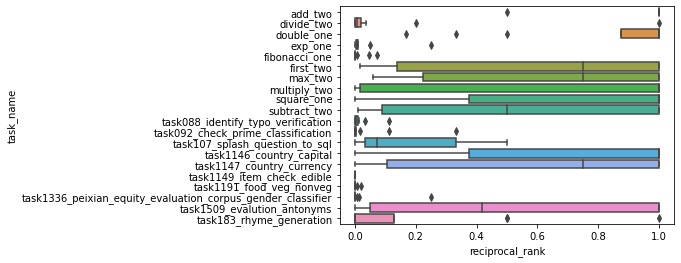

In [26]:
sns.boxplot(data=top_prompts, x="reciprocal_rank", y="task_name")

<AxesSubplot:xlabel='reciprocal_rank', ylabel='exp'>

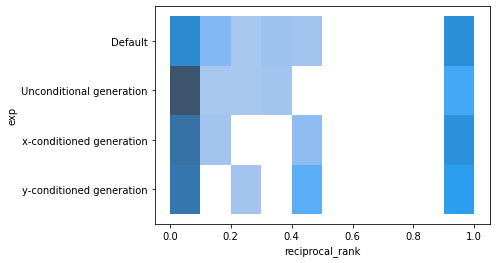

In [31]:
sns.histplot(data=top_prompts, x="reciprocal_rank", y="exp")